In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%load_ext cython

In [31]:
%%cython
import cython
import numpy as np
cimport numpy as np

ctypedef double (*update_rule_t)(long, double, double)

UPDATE_TYPE_MEAN = 0
UPDATE_TYPE_CONSTANT = 1

@cython.boundscheck(False)
@cython.wraparound(False) 
@cython.cdivision(True)
def run_bandits(double[:, :] bandits, double epsilon=0.1, 
                double update_type=UPDATE_TYPE_MEAN):
    cdef long n_bandits, n_times, i, greedy, choice
    cdef double reward
    cdef long[:] take_greedy, random_choices, n_times_chosen
    cdef double[:] action_estimates, reward_at_stage
    cdef update_rule_t update_rule
    
    n_bandits = bandits.shape[0]
    n_times = bandits.shape[1]
    
    if update_type == 0:
        update_rule = sample_average_update
    elif update_type == 1:
        update_rule = constant_step_update
    
    action_estimates = np.zeros(n_bandits, dtype=float)
    n_times_chosen = np.zeros(n_bandits, dtype=int)
    reward_at_stage = np.zeros(n_times, dtype=float)
    
    take_greedy = 1 - np.random.binomial(1, p=epsilon, size=n_times)
    random_choices = np.random.choice(n_bandits, size=n_times)
    for i in range(n_times):
        greedy = take_greedy[i]
        if greedy:
            choice = np.argmax(action_estimates)
        else:
            choice = random_choices[i]
        n_times_chosen[choice] += 1
        reward = bandits[choice, n_times_chosen[choice] - 1]
        action_estimates[choice] += update_rule(
            n_times_chosen[choice], reward, action_estimates[choice])
        reward_at_stage[i] = reward
    return action_estimates, reward_at_stage

cdef double sample_average_update(long n, double reward, double action_estimate):
    return (1/n) * (reward - action_estimate)

cdef double constant_step_update(long n, double reward, double action_estimate):
    return 0.1 * (reward - action_estimate)

In [32]:
def make_stationary_bandits(n_bandits, n_times):
    bandit_means = np.random.normal(size=n_bandits).reshape((n_bandits, 1))
    bandit_draws = np.random.normal(size=(n_bandits, n_times))
    return bandit_means + bandit_draws

def make_nonstationary_bandits(n_bandits, n_times, drift=0.01):
    bandit_means = np.random.normal(size=n_bandits).reshape((n_bandits, 1))
    bandit_drifts = np.cumsum(
        np.random.normal(scale=drift, size=(n_bandits, n_times)),
        axis=1)
    bandit_draws = np.random.normal(size=(n_bandits, n_times)) + bandit_drifts
    return bandit_means + bandit_draws

def non_stationary_bandit_maker(drift=0.01):
    def make_nonstationary_bandits(n_bandits, n_times):
        bandit_means = np.random.normal(size=n_bandits).reshape((n_bandits, 1))
        bandit_drifts = np.cumsum(
            np.random.normal(scale=drift, size=(n_bandits, n_times)),
            axis=1)
        bandit_draws = np.random.normal(size=(n_bandits, n_times)) + bandit_drifts
        return bandit_means + bandit_draws
    return make_nonstationary_bandits

In [33]:
%%timeit
bandits = make_stationary_bandits(n_bandits=10, n_times=10000)
action_estimates, reward_at_stage = run_bandits(bandits)

46.8 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
def bootstrap_bandits(n_bandits=10, n_times=10000, n_bootstraps=1000,
                      epsilon=0.1,
                      bandit_maker=make_stationary_bandits,
                      update_type=UPDATE_TYPE_MEAN):
    reward_at_stages = np.zeros((n_bootstraps, n_times))
    for i in range(n_bootstraps):
        bandits = bandit_maker(n_bandits, n_times)    
        _, reward_at_stage = run_bandits(bandits, epsilon=epsilon, update_type=update_type)
        reward_at_stages[i, :] = reward_at_stage
    return np.mean(reward_at_stages, axis=0)

## Stationary Bandits: Sample Mean Update Rule

In [35]:
n_bootstraps = 100

mean_rewards_greedy = bootstrap_bandits(n_bootstraps=n_bootstraps, epsilon=0.0)
mean_rewards_e1 = bootstrap_bandits(n_bootstraps=n_bootstraps, epsilon=0.1)
mean_rewards_e01 = bootstrap_bandits(n_bootstraps=n_bootstraps, epsilon=0.01)

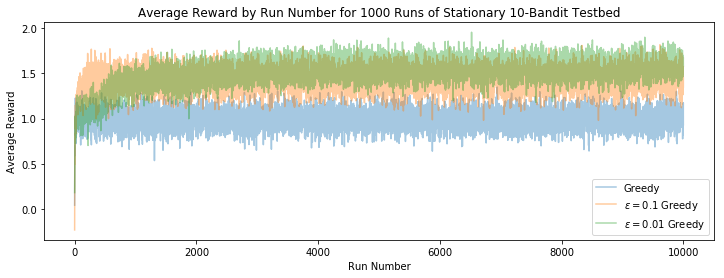

In [36]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(range(10000), mean_rewards_greedy, alpha=0.4,
        label="Greedy")
ax.plot(range(10000), mean_rewards_e1, alpha=0.4,
        label="$\epsilon=0.1$ Greedy")
ax.plot(range(10000), mean_rewards_e01, alpha=0.4,
        label="$\epsilon=0.01$ Greedy")

ax.set_xlabel("Run Number")
ax.set_ylabel("Average Reward")
ax.set_title("Average Reward by Run Number for 1000 Runs of Stationary 10-Bandit Testbed")
plt.legend()

## Stationary Bandits: Constant Update Rule

In [37]:
n_bootstraps = 100

mean_rewards_greedy = bootstrap_bandits(n_bootstraps=n_bootstraps, epsilon=0.0,
                                        update_type=UPDATE_TYPE_CONSTANT)
mean_rewards_e1 = bootstrap_bandits(n_bootstraps=n_bootstraps, epsilon=0.1,
                                    update_type=UPDATE_TYPE_CONSTANT)
mean_rewards_e01 = bootstrap_bandits(n_bootstraps=n_bootstraps, epsilon=0.01,
                                     update_type=UPDATE_TYPE_CONSTANT)

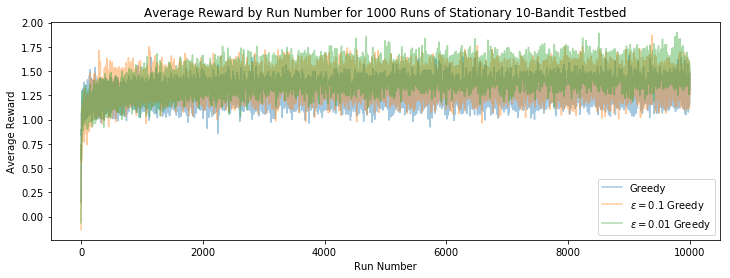

In [38]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(range(10000), mean_rewards_greedy, alpha=0.4,
        label="Greedy")
ax.plot(range(10000), mean_rewards_e1, alpha=0.4,
        label="$\epsilon=0.1$ Greedy")
ax.plot(range(10000), mean_rewards_e01, alpha=0.4,
        label="$\epsilon=0.01$ Greedy")

ax.set_xlabel("Run Number")
ax.set_ylabel("Average Reward")
ax.set_title("Average Reward by Run Number for 1000 Runs of Stationary 10-Bandit Testbed")
plt.legend()

## Non-Stationary Bandits

In [264]:
drifts = [0.01, 0.05, 0.1]
n_bootstraps=25

mean_rewards_greedy = {drift: bootstrap_bandits(
                           n_bootstraps=n_bootstraps, epsilon=0.0, 
                           bandit_maker=non_stationary_bandit_maker(drift=drift))
                       for drift in drifts}
mean_rewards_e1 = {drift: bootstrap_bandits(
                       n_bootstraps=n_bootstraps, epsilon=0.1, 
                       bandit_maker=non_stationary_bandit_maker(drift=drift))
                   for drift in drifts}
mean_rewards_e01 = {drift: bootstrap_bandits(
                        n_bootstraps=n_bootstraps, epsilon=0.01, 
                        bandit_maker=non_stationary_bandit_maker(drift=drift))
                   for drift in drifts}

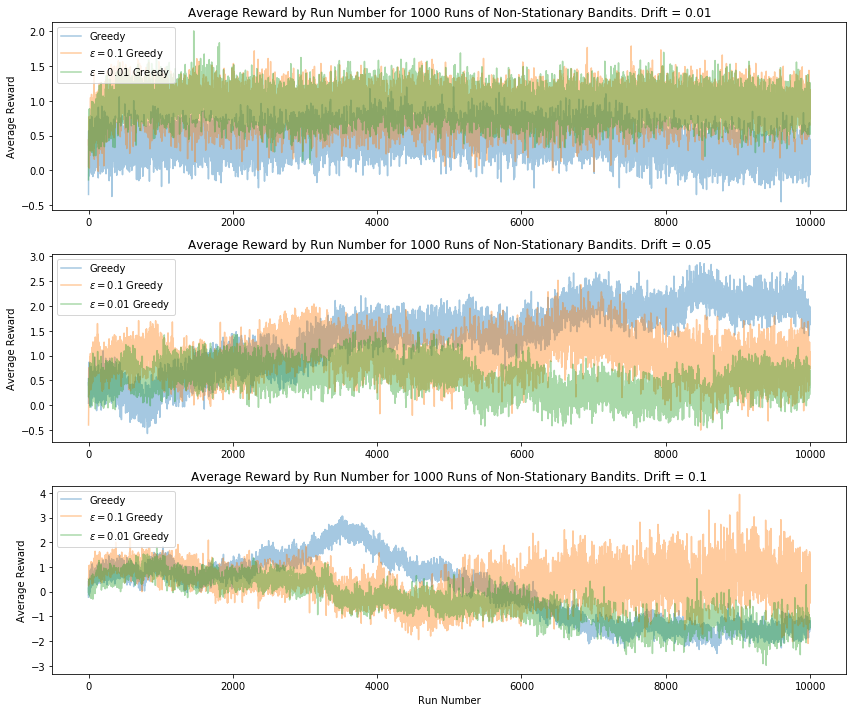

In [265]:
fig, axs = plt.subplots(3, figsize=(12, 10))

for i, (drift, ax) in enumerate(zip(drifts, axs.flatten())):
    ax.plot(range(10000), mean_rewards_greedy[drift], alpha=0.4,
            label="Greedy")
    ax.plot(range(10000), mean_rewards_e1[drift], alpha=0.4,
            label="$\epsilon=0.1$ Greedy")
    ax.plot(range(10000), mean_rewards_e01[drift], alpha=0.4,
            label="$\epsilon=0.01$ Greedy")
    if i == 2:
        ax.set_xlabel("Run Number")
    ax.set_ylabel("Average Reward")
    ax.set_title(f"Average Reward by Run Number for 1000 Runs of Non-Stationary Bandits. Drift = {drift}")
    ax.legend(loc="upper left")
fig.tight_layout()